In [2]:
import xarray as xr 
from pathlib import Path
import numpy as np 
import pandas as pd 
import glob, os
import matplotlib.pyplot as plt
import scipy.interpolate as spi
from datetime import datetime, timedelta


In [3]:
pd.__version__

'1.3.4'

ERA5 for IPRAL
========

In [2]:
oparpath = Path('/home/nmpnguyen/OPAR/LIO3T.daily/2019-04-24.nc4')
d = xr.open_dataset(oparpath)

In [4]:
print('-----GET IPRAL BCK CORRECTED FILE-----')

time = d.time.values
YEAR = pd.to_datetime(time[0]).strftime('%Y')
MONTH = pd.to_datetime(time[0]).strftime('%m')
lon_opar = round(4*float(d['signal'].longitude))/4 #round(float(d.geospatial_lon_min),2)
lat_opar = round(4*float(d['signal'].latitude))/4
print(f'longitude: {lon_opar}')
print(f'latitude: {lat_opar}')
#----


-----GET IPRAL BCK CORRECTED FILE-----
longitude: 55.0
latitude: -21.0


In [5]:
print('-----GET ERA5 FILE-----')
ERA_FOLDER = Path("/bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_PL")
ERA_FILENAME = YEAR+MONTH+".ap1e5.GLOBAL_025.nc"
GEOPT_PATH = ERA_FOLDER / YEAR / Path("geopt."+ERA_FILENAME)
TA_PATH = ERA_FOLDER / YEAR / Path("ta."+ERA_FILENAME)
print(f'path of temperature {TA_PATH}')
print(f'path of geopotential {GEOPT_PATH}')
geopt = xr.open_dataset(GEOPT_PATH)
ta = xr.open_dataset(TA_PATH)
#----


-----GET ERA5 FILE-----
path of temperature /bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_PL/2019/ta.201904.ap1e5.GLOBAL_025.nc
path of geopotential /bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_PL/2019/geopt.201904.ap1e5.GLOBAL_025.nc


In [7]:
print('-----CONVERT TIME AND LOCALISATION-----')
# date_start = pd.to_datetime(time[0])
# date_end = pd.to_datetime(time[-1])
time = pd.to_datetime(time).strftime('%Y-%m-%dT%H:00:00.000000000')
time = time.astype('datetime64[ns]')
time_unique = np.unique(time)
LAT = geopt.latitude[np.where(np.abs(geopt.latitude.values - lat_opar) <=0.25)[0][1]].values
LON = geopt.longitude[np.where(np.abs(geopt.longitude.values - lon_opar) <=0.25)[0][1]].values
#----
from timeit import default_timer as timer
TIME = timer()
geopt_for_ipral = geopt.sel(time=time_unique, latitude=LAT, longitude=LON).to_dataframe()#['geopt']
ta_for_ipral = ta.sel(time=time_unique, latitude=LAT, longitude=LON).to_dataframe()#['ta']
print(f'Time loading {timer()-TIME}')
#----


-----CONVERT TIME AND LOCALISATION-----
Time loading 9.326546353986487


In [8]:
print('-----GETTING PRESSURE AND TEMPERATURE-----')
lat_opar = np.deg2rad(lat_opar)
acc_gravity = 9.78032*(1+5.2885e-3*(np.sin(lat_opar))**2 - 5.9e-6*(np.sin(2*lat_opar))**2)
r0 = 2*acc_gravity/(3.085462e-6 + 2.27e-9*np.cos(2*lat_opar) - 2e-12*np.cos(4*lat_opar))
g0 = 9.80665
geopt_for_ipral['geopt_height'] = geopt_for_ipral["geopt"]/g0
geopt_for_ipral['altitude'] = (geopt_for_ipral['geopt_height']*r0)/(acc_gravity*r0/g0 - geopt_for_ipral['geopt_height'])
M = 28.966E-3 
R = 8.314510
T = (15 + 273.15)
const = -(M*g0)/(R*T)
p0 = 101325
geopt_for_ipral['pression'] = p0*np.exp(const*geopt_for_ipral['altitude'])
output_era = pd.merge(geopt_for_ipral, ta_for_ipral['ta'], left_index=True, right_index=True) 
print('variables_from_era --> end')

-----GETTING PRESSURE AND TEMPERATURE-----
variables_from_era --> end


In [75]:
import scipy.interpolate as spi
def interpolate_atb_mol(lidar_name, opar_file, era):     
    """
    the Input is the output dataframe of simulate_atb_mol function
    """
    print('-----BEFORE INTERPOLATE-----')
    d = xr.open_dataset(opar_file)
    r = d.range.values*1e3 + 2160
    timeOpar = d.time.values
    timeEra = np.unique(era.index.get_level_values(1)) 
    time_tmp = np.array(pd.to_datetime(timeOpar).strftime('%Y-%m-%dT%H:00:00')).astype('datetime64[ns]')
    if len(time_tmp) != len(timeOpar):
        print("Time Error")
        sys.exit(1)
    #------
    columns_names = ['altitude', 'pression', 'ta']#, 'beta355mol', 'beta532mol', 'beta355', 'beta532', 'alpha355', 'alpha532', 'tau355', 'tau532'
    pression_interp, ta_interp = [[] for _ in range(len(columns_names)-1)] #beta355mol_interp ,beta532mol_interp, beta355_interp ,beta532_interp ,tau355_interp ,tau532_interp ,alpha355_interp ,alpha532_interp ,
    new_index = pd.MultiIndex.from_product([timeEra, r], names = ['time', 'range'])
    # df_new = pd.DataFrame(index = new_index, columns = era.columns)
    print('-----INTERPOLATE ATTENUATED BACKSCATTERING FROM ERA5-----')
    for t1 in timeEra:
        a = era.loc[pd.IndexSlice[:, t1], columns_names]
        f9 = spi.interp1d(a['altitude'], a['pression'], kind = 'linear', bounds_error=False, fill_value="extrapolate")
        f10 = spi.interp1d(a['altitude'], a['ta'], kind = 'linear', bounds_error=False, fill_value="extrapolate")
        pression_interp, ta_interp = np.append(pression_interp, np.array(f9(r))), np.append(ta_interp, np.array(f10(r)))

    new_df = pd.DataFrame(index = new_index, data = np.array([pression_interp, ta_interp]).T, columns = columns_names[1:]) # ,beta355mol_interp ,beta532mol_interp
    #, beta355_interp ,beta532_interp ,alpha355_interp ,alpha532_interp ,tau355_interp ,tau532_interp
    
    print(Path("/homedata/nmpnguyen/OPAR/Processed/",lidar_name.upper(),opar_file.name.split('.')[0]+"_simul.pkl"))
#     new_df.to_pickle(Path("/homedata/nmpnguyen/OPAR/Processed/",lidar_name.upper(),opar_file.name.split('.')[0]+"_simul.pkl"))
    print('interpolate_atb_mol --> end')
    return new_df

In [76]:
output = interpolate_atb_mol("lio3t", oparpath, output_era)

-----BEFORE INTERPOLATE-----
-----INTERPOLATE ATTENUATED BACKSCATTERING FROM ERA5-----
/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-04-24_simul.pkl
interpolate_atb_mol --> end


In [69]:
pres = output_era['pression'].unstack(level=1).iloc[:,0]
ta = output_era['ta'].unstack(level=1).iloc[:,0]
alt = output_era['altitude'].unstack(level=1).iloc[:,0]


In [62]:
'''
2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
Et calculer son integrale entre zmin et zmax
'''
def get_backscatter_mol(p, T, w):
    '''
    Fonction permet de calculer le coef. de backscatter moléculaire 
    p(Pa), T(K), w(um)
    '''
    k = 1.38e-23
    betamol = p/(k*T) * 5.45e-32 * (w/0.55)**(-4.09)
    alphamol = betamol/0.119
    return alphamol, betamol


AlphaMol, BetaMol = get_backscatter_mol(pres, ta, 0.532)
print(BetaMol)


level
1       5.829414e-09
2       1.125451e-08
3       1.638715e-08
5       2.640722e-08
7       3.568209e-08
10      4.885118e-08
20      8.877106e-08
30      1.237499e-07
50      1.894602e-07
70      2.517414e-07
100     3.227618e-07
125     3.716187e-07
150     4.077231e-07
175     4.392718e-07
200     4.705226e-07
225     5.040080e-07
250     5.364736e-07
300     5.970731e-07
350     6.623674e-07
400     7.247655e-07
450     7.878087e-07
500     8.517860e-07
550     9.177157e-07
600     9.843938e-07
650     1.049139e-06
700     1.116262e-06
750     1.180942e-06
775     1.213379e-06
800     1.246150e-06
825     1.280660e-06
850     1.314769e-06
875     1.348909e-06
900     1.383255e-06
925     1.418074e-06
950     1.451536e-06
975     1.483848e-06
1000    1.514759e-06
Name: 2019-04-24 15:00:00, dtype: float64


In [78]:
output.to_pickle('/home/nmpnguyen/ear5withoutinterp.pkl')

In [2]:
pd.read_pickle('/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-04-24_simul.pkl')

pression          ta
time                range                             
2019-04-24 15:11:05 2160.0    78441.505331  287.682303
                    2167.5    78372.030431  287.640497
                    2175.0    78302.555531  287.598691
                    2182.5    78233.080631  287.556886
                    2190.0    78163.605731  287.515080
...                                    ...         ...
2019-04-24 18:07:25 124972.5  -3916.642842  395.002043
                    124980.0  -3917.058071  395.015156
                    124987.5  -3917.473301  395.028268
                    124995.0  -3917.888530  395.041381
                    125002.5  -3918.303760  395.054494

[1441440 rows x 2 columns]

In [64]:
simulpklpath = sorted(Path("/homedata/nmpnguyen/IPRAL/RF/Simul/").glob('ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440*.pkl'))[0]
print(simulpklpath)
data = pd.read_pickle(simulpklpath)

# !pip3 install pickle5
# import pickle5 as pickle
# with open(simulpklpath, "rb") as fh:
#   data = pickle.read(fh)
# data = pickle.load( open( simulpklpath, "rb" ) )

/homedata/nmpnguyen/IPRAL/RF/Simul/ipral_1a_Lz1R15mF30sPbck_v01_20180909_000000_1440_simul.pkl


In [69]:
# pression = data['pression'].unstack()
pression.iloc[585]

range
15.0       101106.038444
30.0       100931.613413
45.0       100757.188382
60.0       100582.763351
75.0       100408.338320
               ...      
59940.0      -292.135871
59955.0      -292.940729
59970.0      -293.745587
59985.0      -294.550444
60000.0      -295.355302
Name: 2018-09-09 05:00:42, Length: 4000, dtype: float64

In [67]:
temperature = data['ta'].unstack()
np.array(temperature.iloc[285]), np.array(pd.DataFrame(temperature.iloc[285]).index)

(array([288.89935303, 289.01864624, 289.13793945, ..., 267.97174072,
        267.98101807, 267.99032593]),
 array([1.5000e+01, 3.0000e+01, 4.5000e+01, ..., 5.9970e+04, 5.9985e+04,
        6.0000e+04]))

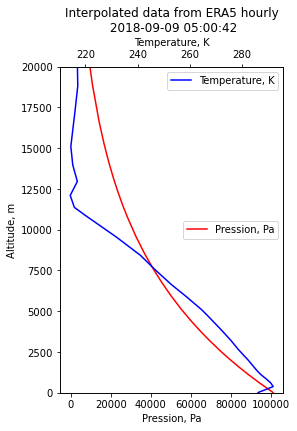

In [72]:
fig, ax = plt.subplots(figsize=(4,6))
ax.plot(np.array(pression.iloc[585]), np.array(pd.DataFrame(pression.iloc[285]).index), 
        label='Pression, Pa', color='r')
ax.set_ylim(0, 20000)
ax.set(ylabel='Altitude, m', xlabel='Pression, Pa', title = 'Interpolated data from ERA5 hourly\n 2018-09-09 05:00:42')

ax2 = ax.twiny()
ax2.set(xlabel='Temperature, K')
ax2.plot(np.array(temperature.iloc[585]), np.array(pd.DataFrame(temperature.iloc[285]).index), 
         label='Temperature, K', color='b')

ax.legend(loc='right')
ax2.legend()

# plt.gca().invert_yaxis()

# plt.savefig('tempe_pression_illutra2022.png')